<a href="https://colab.research.google.com/github/pgurazada/langchain-agents/blob/main/custom_agents_mistral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Objectives

- Create custom agents for open-source LLMs using `langchain` tools
- Understand how the ReAct paradigm is used to compose agent behavior with open-source LLMs

# Setup

In [1]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install -q llama-cpp-python==0.2.55

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 9.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.2 MB/s eta 0:00:00


In [ ]:
!pip install -q langchain==0.1.9 \
                langchainhub==0.1.14 \
                langchain_experimental==0.0.52 \
                duckduckgo-search==4.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.0/817.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.6/171.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.6/252.6 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 20.0 MB/s eta 0:00:00


In [ ]:
import json

from huggingface_hub import hf_hub_download
from llama_cpp import Llama

from langchain.agents import Tool
from langchain.tools import DuckDuckGoSearchRun, yahoo_finance_news
from langchain_experimental.utilities import PythonREPL

In [ ]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q5_K_M.gguf"

In [ ]:
mistral_model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mistral-7b-instruct-v0.2.Q5_K_M.gguf:   0%|          | 0.00/5.13G [00:00<?, ?B/s]

In [ ]:
mistral = Llama(
    model_path=mistral_model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=43, # Change this value based on your model and your GPU VRAM pool.
    n_ctx=4096 # Context window
)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q5_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loa

In [ ]:
mistral.verbose = False

# Custom Agents

## Overview

The overall framework to create custom agents is presented in the figure below.

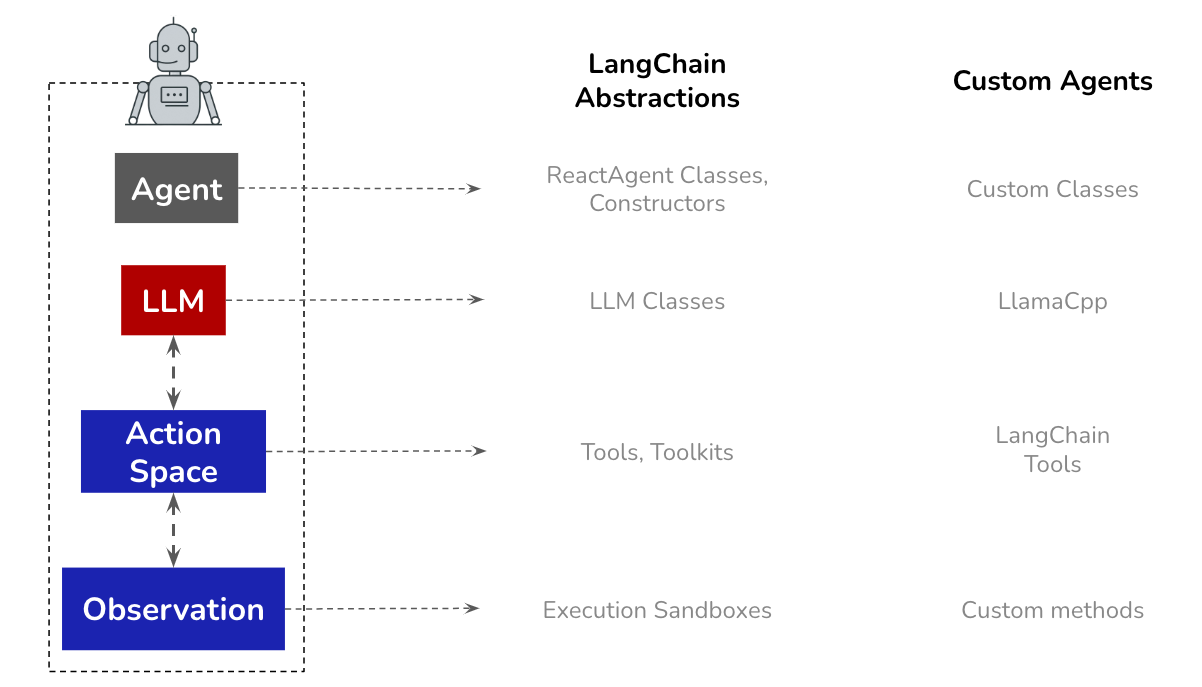

(Robot Image Source: Google Gemini)

As the figure indicates, we utilize the `Tool` classes from LangChain and wrap custom `Agent` classes around these tools. Each agent follows a clearly defined prompt template that guides tool usage. Execution of tools as prescribed by the large language model is accomplished through custom methods.

Let us now build a few custom agents using the tooling from `langchain` as an illustration of how these agents could be constructed.

## Example 1: Python Agent

To create a Python agent that translates user instructions to a Python script that is then executed, we use the `PythonREPL` tool from `langchain`.

In [ ]:
python_repl = PythonREPL()

In [ ]:
python_repl.schema()

{'title': 'PythonREPL',
 'description': 'Simulates a standalone Python REPL.',
 'type': 'object',
 'properties': {'_globals': {'title': ' Globals', 'type': 'object'},
  '_locals': {'title': ' Locals', 'type': 'object'}}}

In [ ]:
repl_tool = Tool(
    name="python_repl",
    description="A Python shell used to execute python commands. Input should be a valid python command.",
    func=python_repl.run,
)

In [ ]:
repl_tool.invoke('print("Hello World!")')

'Hello World!\n'

We will need a prompt template that instructs the LLM to generate Python code to accomplish the objectives specified in the user input.

In [ ]:
tool_prompt_template = """[INST]
Create Python code to execute the following task:
{user_task}

Output only the code. Do not include anything else in your output.
[/INST]
"""

Let us test this prompt template out using an example task.

In [ ]:
task = "Convert 39 degrees Celsius to Farenheit."

In [ ]:
response = mistral(
    prompt=tool_prompt_template.format(user_task=task),
    max_tokens=256,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False
)

In [ ]:
output = response["choices"][0]["text"].strip()

In [ ]:
print(output)

```python
celsius = 39.0
fahrenheit = (celsius * 9 / 5) + 32
print(fahrenheit)
```


As the output above indicates, the LLM implements the Celsius to Farenheit conversion formula to a simple Python script enclosed within ` ```python ` and ` ``` `.

In order to execute this code, we will need to parse this output and extract the script. This amounts to finding these markers and indexing into the script using these markers.

In [ ]:
start_index = output.rfind('```python')
end_index = output.rfind('```')

In [ ]:
start_index, end_index

(0, 79)

In [ ]:
output[start_index+9:end_index] # ```python is 9 characters long, the script starts after

'\ncelsius = 39.0\nfahrenheit = (celsius * 9 / 5) + 32\nprint(fahrenheit)\n'

Now that we have the script extracted, we can invoke the `repl_tool` to run this short script.

In [ ]:
repl_tool.invoke(output[start_index+9:end_index])

'102.2\n'

We now have all the components needed to build the agent. Here is an implementation of this agent. Notice how the run method extracts the Python code from the LLM output and then uses the `repl_tool` to execute this code. The reasoning is performed by the LLM and the action is performed by the tool.

In [ ]:
class PythonAgent:
  """
  An agent that can be used to execute tasks using the Python repl.

  Args:
    llm (LLM): The LLM to use.
    tool (Tool): The tool to use.
  """
  def __init__(self, llm, tool):
    self.llm = llm
    self.tool = tool
    self.tool_prompt_template = """[INST]
    Create Python code to execute the following task:
    {user_task}
    Output only the code. Do not include anything else in your output.
    [/INST]
    """
    self.script = None # Place holder for the Python script that will be generated during runtime

  def run(self, user_task):
    response = self.llm(
        prompt=self.tool_prompt_template.format(user_task=user_task),
        max_tokens=256,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        echo=False
    )
    output = response["choices"][0]["text"].strip()

    # Parse Output
    start_index = output.find('```python')
    end_index = output.rfind('```')

    python_script = output[start_index+9:end_index]

    self.script = python_script

    # Execute script

    try:
      result = self.tool.invoke(python_script)
    except Exception as e:
      result = str(e)

    return result

Let us now instantiate and test the agent out.

In [ ]:
python_agent = PythonAgent(mistral, repl_tool)

In [ ]:
result = python_agent.run("Convert 39 degrees Celsius to Farenheit.")

In [ ]:
print(result)

102.2



We can access the inner working of the agent by inspecting the script that was generated.

In [ ]:
print(python_agent.script)


celsius = 39.0
fahrenheit = (celsius * 9 / 5) + 32
print(fahrenheit)



Let us now focus the agent on a more difficult problem.

In [ ]:
math_problem = "A town has a population of 12,000." \
               " The population increases by 12% per year." \
               " What will be the population after 3 years?"

In [ ]:
result = python_agent.run(math_problem)

In [ ]:
print(result)

16859



Let us now inspect the script that was generated to solve this problem.

In [ ]:
print(python_agent.script)


population = 12000
growth_rate = 0.12
num_years = 3
population_future = population * (1 + growth_rate) ** num_years
print(int(population_future))



## Example 2: Search Agent

Let us now build a search agent that follows the ReAct framework (as implemented in `langchain`). This means that the agent will follow the ReAct prompt that includes the Thought - Action - Observation chain. As we did with the Python agent, let us first build out the LLM prompt assembly and execution.

We begin by creating a search tool that essentially wraps the DuckDuckGo API.

In [ ]:
duckduckgo_search = DuckDuckGoSearchRun()

In [ ]:
search_tool = Tool(
    name="duckduckgo_search",
    description="An interface to the DuckDuckGo search engine. Input should be a string.",
    func=duckduckgo_search.run,
)

Let us now craft the ReAct prompt designed following `langchain` guidelines.

In [ ]:
react_prompt_template = """[INST]
Answer the following questions as best you can. You have access to the following tool:

search_tool: An interface to the DuckDuckGo search engine. Input should be a string.

The way you use the tool is by specifying a json blob.
Specifically, this json should have a `action` key (with the name of the tool to use) and a `action_input` key (with the input to the tool going here).

The only values that should be in the "action" field are:
search_tool: A function to search the DuckDuckGo search engine

The $JSON_BLOB should only contain a SINGLE action and MUST be formatted as markdown, do NOT return a list of multiple actions. Here is an example of a valid $JSON_BLOB:

```
{{
  "action": $TOOL_NAME,
  "action_input": $INPUT
}}
```
Make sure to have the $INPUT in the right format for the tool you are using, and do not put variable names as input if you can find the right values.

ALWAYS use the following format:

Question: the input question you must answer
Thought: you should always think about one action to take. Only one action at a time in this format:
Action:
```
$JSON_BLOB
```
Question: {user_question}

[/INST]
"""

In [ ]:
response = mistral(
        prompt=react_prompt_template.format(user_question="What is the latest stock price of AAPL?"),
        max_tokens=4096,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        echo=False
)

In [ ]:
output = response["choices"][0]["text"].strip()

In [ ]:
print(output)

Thought: I need to find the latest stock price of AAPL using a web search and then extract that information from the search results.
Action:
```json
{
  "action": "search_tool",
  "action_input": "What is the latest stock price of AAPL?"
}
```


As the above output indicates, the tool choice and the input to the tool are delimited by ` ```json` and ` ``` `. This allows us to write an output parser to extract the action parameters (i.e., the tool and its inputs).

In [ ]:
start_index = output.find('```json')
end_index = output.rfind('```')

In [ ]:
print(output[start_index+7:end_index])


{
  "action": "search_tool",
  "action_input": "What is the latest stock price of AAPL?"
}



We can now assemble our search agent with this tool.

In [ ]:
class SearchAgent:
  """
  This agent will use the search tool to answer questions.
  """
  def __init__(self, llm, tool, prompt_template):
    self.llm = llm
    self.tool = tool
    self.tool_prompt_template = prompt_template
    self.verbose = True

  def run(self, question):
    response = self.llm(
        prompt=self.tool_prompt_template.format(user_question=question),
        max_tokens=4096,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        echo=False
    )

    output = response["choices"][0]["text"].strip()

    if self.verbose:
      print(output)

    # Parse Output
    start_index = output.find('```json')
    end_index = output.rfind('```')

    tool_choice = json.loads(output[start_index+7:end_index])
    tool_input = tool_choice["action_input"]

    # Execute search
    try:
      search_result = self.tool.invoke(tool_input)
    except Exception as e:
      search_result = "Cannot find relevant information"

    # Answer the question

    answering_prompt = f"""
    [INST]Given the context:\n {search_result}, answer the following question based on this context:\n {question}.
    Do not include information about the context.[/INST]"""

    final_response = self.llm(
        prompt=answering_prompt,
        max_tokens=4096,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        echo=False
    )

    return final_response["choices"][0]["text"].strip()

In [ ]:
search_agent = SearchAgent(mistral, search_tool, react_prompt_template)

In [ ]:
search_agent.run(question="What is the latest stock price of AAPL?")

Thought: I need to find the latest stock price of AAPL using a web search and then extract that information from the search results.
Action:
```json
{
  "action": "search_tool",
  "action_input": "What is the latest stock price of AAPL?"
}
```


'The latest stock price of AAPL is 164.86.'

In [ ]:
search_agent.run(question="What was Tesla's quarterly revenue from the latest earnings call?")

Thought: I will use the search tool to find out Tesla's latest quarterly revenue from their earnings call.
Action:
```json
{
  "action": "search_tool",
  "action_input": "Tesla latest quarterly revenue earnings call"
}
```


'The quarterly revenue for Tesla from the latest earnings call was $25.17 billion.'

Notice that the implementation of the agent above implements one loop of the Thought - Action - Observation chain. For the instances above, one execution of the chain was enough to get us the correct answer. What about the full chain of Thought - Action - Observation steps that `langchain` agents execute till they reach the final answer?

To accomplish potentially multiple steps that an agent might have to take to reach their answer, we will need to add an evaluation stage that confirms at the end of each Thought - Action - Observation chain if the final answer is achieved or not. This process is illustrated in the figure below.

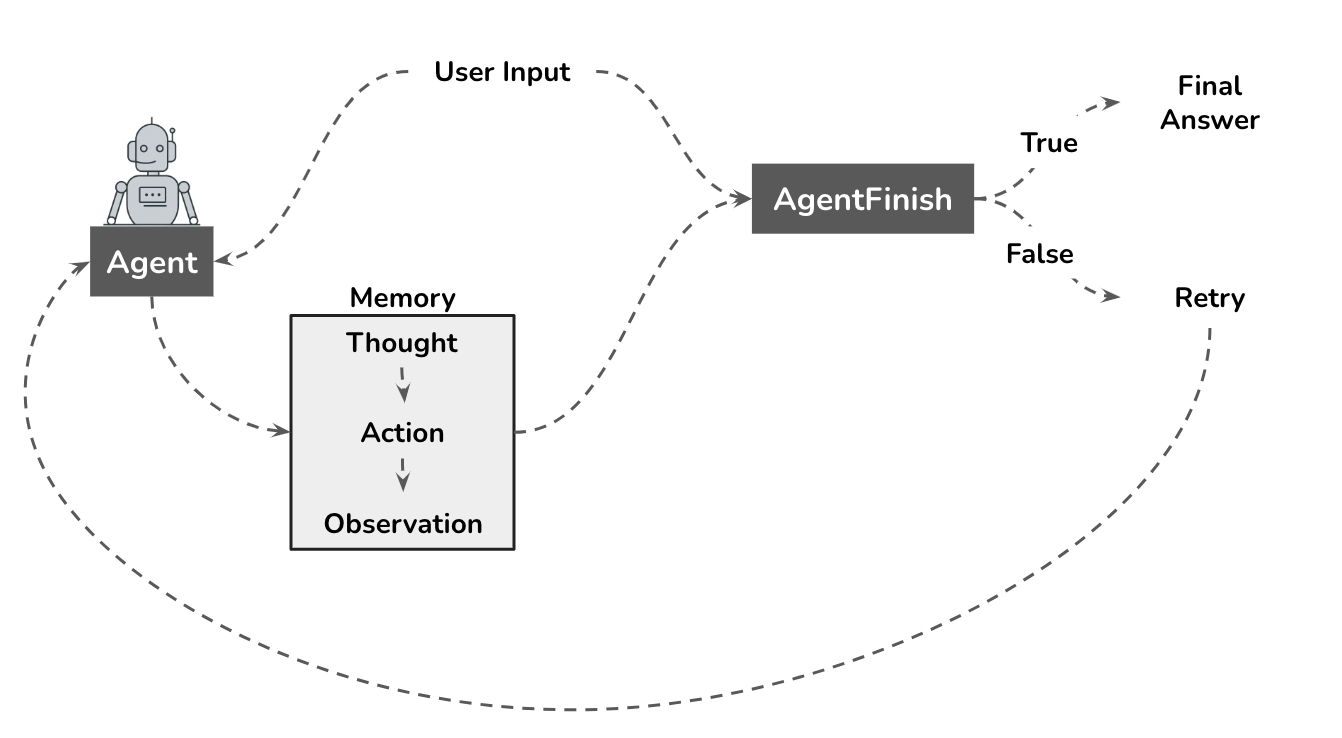

(Robot Image Source: Google Gemini)

As the above figure indicates, we will need to implement two classes - one for the agent execution (creating a Thought - Action - Observation chain in each run) and another that implements a stopping criterion that checks if the final answer has been reached.

In [ ]:
class SearchReactAgent:
  """
  This agent will use the search tool to answer questions.
  It will store intermediate steps in memory.
  """
  def __init__(self, llm, tool, prompt_template):
    self.llm = llm
    self.tool = tool
    self.tool_prompt_template = prompt_template
    self.observation = None
    self.memory = ''
    self.final_answer = None

  def run(self, question):

    # Thought: Plan based on the user question
    search_prompt = self.tool_prompt_template.format(user_question=question)

    response = self.llm(
        prompt=search_prompt,
        max_tokens=4096,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        echo=False
    )

    output = response["choices"][0]["text"].strip()

    # Parse plan for action input

    start_index = output.find('```json')
    end_index = output.rfind('```')

    tool_choice = json.loads(output[start_index+7:end_index])
    tool_input = tool_choice["action_input"]

    # Action: Execute search
    try:
      search_result = self.tool.invoke(tool_input)
    except Exception as e:
      search_result = "Cannot find relevant information"

    # Observation: Store the outcome of the action in memory

    # Answer the question

    answering_prompt = f"""
    [INST]Given the context:\n {search_result}, answer the following question based on this context:\n {question}.
    Do not include information about the context.[/INST]"""

    answer = self.llm(
        prompt=answering_prompt,
        max_tokens=4096,
        temperature=0.2,
        top_p=0.95,
        repeat_penalty=1.2,
        echo=False
    )

    self.observation = answer["choices"][0]["text"].strip()

    self.memory += (output + '\n' + f"Observation: {self.observation}" + '\n')

    return None

In [ ]:
search_react_agent = SearchReactAgent(mistral, search_tool, react_prompt_template)

In [ ]:
search_react_agent.run(question="What is the latest stock price of AAPL?")

In [ ]:
print(search_react_agent.memory)

Thought: I need to find the latest stock price of AAPL using a web search and then extract that information from the search results.
Action:
```json
{
  "action": "search_tool",
  "action_input": "What is the latest stock price of AAPL?"
}
```
Observation: The latest stock price of AAPL is 164.86.



As the output above indicates, the memory of the agent stores the first Thought - Action - Observation chain. Repeated runs of this agent will keep adding these chains to memory.

In [ ]:
search_react_agent.run(question="What is the latest stock price of AAPL?")

In [ ]:
print(search_react_agent.memory)

Thought: I need to find the latest stock price of AAPL using a web search and then extract that information from the search results.
Action:
```json
{
  "action": "search_tool",
  "action_input": "What is the latest stock price of AAPL?"
}
```
Observation: The latest stock price of AAPL is 164.86.
Thought: I need to find the latest stock price of AAPL using a web search and then extract that information from the search results.
Action:
```json
{
  "action": "search_tool",
  "action_input": "What is the latest stock price of AAPL?"
}
```
Observation: The latest stock price of AAPL is 164.86.



The final piece in agent creation is to implement a stopping criterion, that is, a signal to the agent that the final answer has been reached and that there is no further execution of tooling that is required.

In [ ]:
class AgentFinish:
  """
  This class will check if the agent has reached the final solution.
  It accesses the memory of the agent to check if the final answer has been reached.
  """
  def __init__(self, llm, agent):
    self.llm = llm
    self.agent = agent

  def run(self, question):
    checking_prompt = f"""
    [INST]Given the following status of the thought process of a LLM agent:\n {self.agent.memory},
    verify if the observation of the agent is enough to answer the following question:\n {question}.
    Answer only as yes or no (single word). Do not include any other information.[/INST]"""

    answer = self.llm(
        prompt=checking_prompt,
        max_tokens=3,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        echo=False
    )

    finish_status = answer["choices"][0]["text"].strip().lower().replace(".", '')

    return finish_status

Let us run the checker on the agent we ran for a couple of times in the previous stage.

In [ ]:
finish_checker = AgentFinish(mistral, search_react_agent)

In [ ]:
finish_checker.run(question="What is the latest stock price of AAPL?")

'yes'

Now that we have both the steps, we can compose a loop that executes the ReAct thought chains till the final answer is reached.

In [ ]:
user_input = "What is the latest stock price of AAPL?"
finish_status = False

search_react_agent = SearchReactAgent(mistral, search_tool, react_prompt_template)

while not finish_status:

  search_react_agent.run(user_input)
  finish_checker = AgentFinish(mistral, search_react_agent)
  finish_status = (finish_checker.run(user_input)=="yes")

# The final answer is the last observation of the agent
# A more involved implementation could look at all the observations of the agent
# and invoke the LLM to compose a more nuanced answer.

search_react_agent.final_answer = search_react_agent.observation

print(f"Input: {user_input}")
print(f"Output: {search_react_agent.final_answer}")

Input: What is the latest stock price of AAPL?
Output: The latest stock price of AAPL is 164.86.
